In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.graphics.api as smg

from ISLP import (load_data, confusion_table)
from ISLP.models import (ModelSpec as MS, summarize, contrast)

from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA, \
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Weekly dataset

In [2]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
corr = Weekly.loc[:, Weekly.columns != 'Direction'].corr()
corr

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


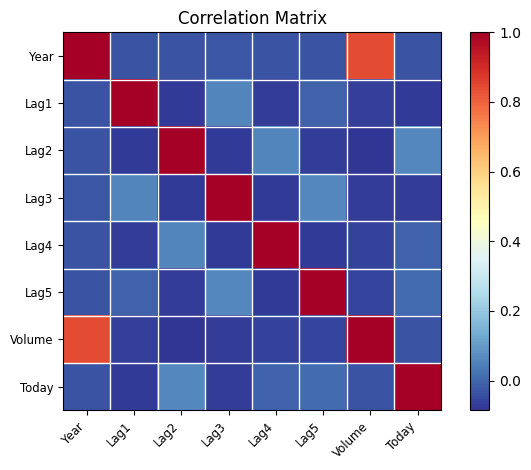

In [4]:
smg.plot_corr(
    corr.values, 
    xnames=Weekly.columns.drop('Direction'), 
    ynames=Weekly.columns.drop('Direction')
);

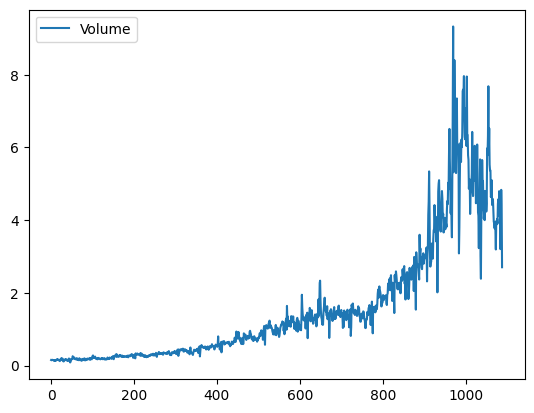

In [5]:
Weekly.plot(y='Volume');

### Logistic regression

In [6]:
preds = Weekly.columns.drop(['Today', 'Direction', 'Year'])
spec = MS(preds)
X = spec.fit_transform(Weekly)
y = Weekly['Direction'] == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


In [7]:
probs = results.predict()
probs[:10]

array([0.60862494, 0.60103144, 0.58756995, 0.48164156, 0.61690129,
       0.56841902, 0.57860971, 0.51519724, 0.57151998, 0.55542873])

In [8]:
n, p = Weekly.shape
n, p

(1089, 9)

In [9]:
labels = np.array(['Down']*n)
labels[probs>.5] = 'Up'
labels

array(['Up', 'Up', 'Up', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [10]:
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [11]:
np.mean(labels == Weekly.Direction)

0.5610651974288338

### LDA

In [12]:
train = (Weekly.Year < 2009)
Weekly_train = Weekly.loc[train]
Weekly_train.tail()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
980,2008,12.026,-8.389,-6.198,-3.898,10.491,5.841565,-2.251,Down
981,2008,-2.251,12.026,-8.389,-6.198,-3.898,6.093950,0.418,Up
982,2008,0.418,-2.251,12.026,-8.389,-6.198,5.932454,0.926,Up
983,2008,0.926,0.418,-2.251,12.026,-8.389,5.855972,-1.698,Down
984,2008,-1.698,0.926,0.418,-2.251,12.026,3.087105,6.760,Up


In [13]:
Weekly_test = Weekly.loc[~train]
Weekly_test.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
985,2009,6.760,-1.698,0.926,0.418,-2.251,3.793110,-4.448,Down
986,2009,-4.448,6.760,-1.698,0.926,0.418,5.043904,-4.518,Down
987,2009,-4.518,-4.448,6.760,-1.698,0.926,5.948758,-2.137,Down
988,2009,-2.137,-4.518,-4.448,6.760,-1.698,6.129763,-0.730,Down
989,2009,-0.730,-2.137,-4.518,-4.448,6.760,5.602004,5.173,Up


In [14]:
spec = MS(['Lag2']).fit(Weekly)
X = spec.transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]

In [15]:
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [16]:
lda = LDA(store_covariance=True)

In [17]:
X_train, X_test = [
    M.drop(columns=['intercept']) for M in [X_train, X_test]
]
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [18]:
lda.means_

array([[-0.03568254],
       [ 0.26036581]])

In [19]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [20]:
# prior probability estimates
lda.priors_

array([0.44771574, 0.55228426])

In [21]:
# linear discriminant vectors
lda.scalings_

array([[0.44141622]])

In [22]:
lda_pred = lda.predict(X_test)

In [23]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [24]:
np.mean(lda_pred == L_test)

0.625

### QDA

In [25]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [26]:
qda.means_, qda.priors_

(array([[-0.03568254],
        [ 0.26036581]]),
 array([0.44771574, 0.55228426]))

In [27]:
qda.covariance_[0]

array([[4.83781758]])

In [28]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [29]:
np.mean(qda_pred == L_test)

0.5865384615384616

### Naive Bayes

In [30]:
NB = GaussianNB()
NB.fit(X_train, L_train)

,priors,None
,var_smoothing,1e-09


In [31]:
nb_pred = NB.predict(X_test)
confusion_table(nb_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [32]:
np.mean(nb_pred == L_test)

0.5865384615384616

### KNN

In [33]:
knn4 = KNN(n_neighbors=4)
knn4.fit(X_train, L_train)
knn4_pred = knn4.predict(X_test)
confusion_table(knn4_pred, L_test)

Truth,Down,Up
Predicted,,
Down,26,27
Up,17,34


In [34]:
np.mean(knn4_pred == L_test)

0.5769230769230769

## Auto dataset

In [35]:
Auto = load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [36]:
mpg01 = Auto['mpg'] > Auto['mpg'].median()
Auto['mpg01'] = mpg01

In [37]:
Auto[mpg01 == 1]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
name,,,,,,,,,
toyota corona mark ii,24.0,4,113.0,95,2372,15.0,70,3,True
datsun pl510,27.0,4,97.0,88,2130,14.5,70,3,True
volkswagen 1131 deluxe sedan,26.0,4,97.0,46,1835,20.5,70,2,True
peugeot 504,25.0,4,110.0,87,2672,17.5,70,2,True
audi 100 ls,24.0,4,107.0,90,2430,14.5,70,2,True
...,...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1,True
vw pickup,44.0,4,97.0,52,2130,24.6,82,2,True
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1,True


In [38]:
Auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,0.836939
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.759194
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.753477
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.667053
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.757757
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.346822
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.429904
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.513698
mpg01,0.836939,-0.759194,-0.753477,-0.667053,-0.757757,0.346822,0.429904,0.513698,1.000000


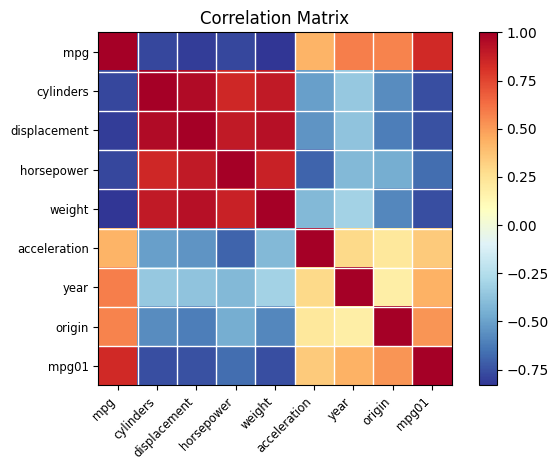

In [39]:
smg.plot_corr(
    Auto.corr(), 
    xnames=Auto.columns, 
    ynames=Auto.columns,
);

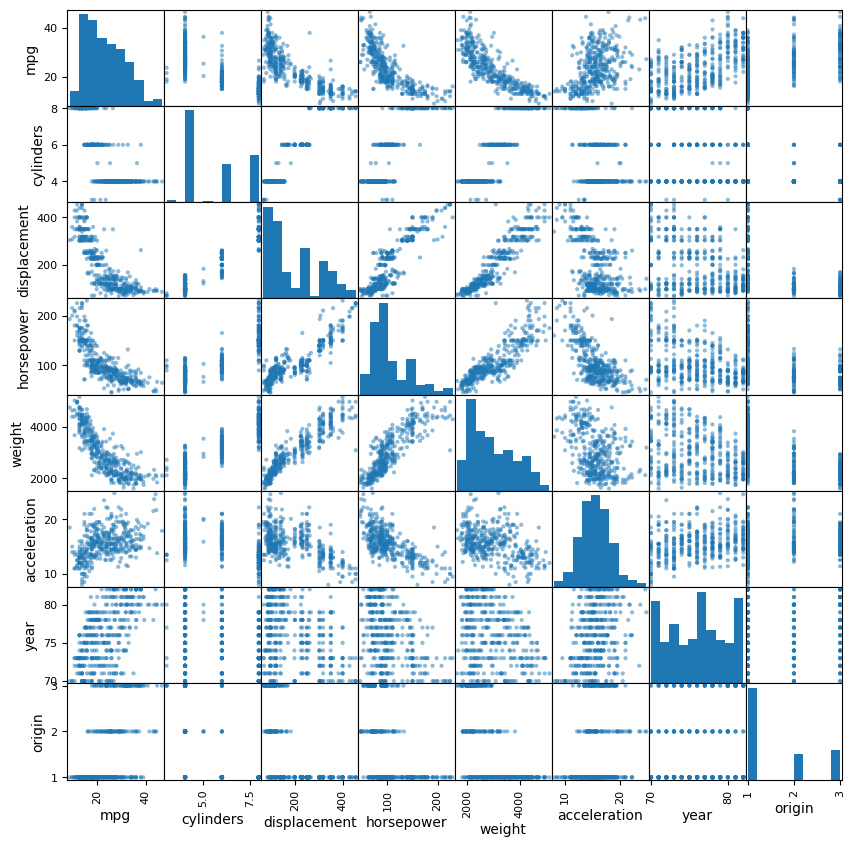

In [40]:
pd.plotting.scatter_matrix(Auto.loc[:, Auto.columns != 'mpg01'], figsize=(10, 10));

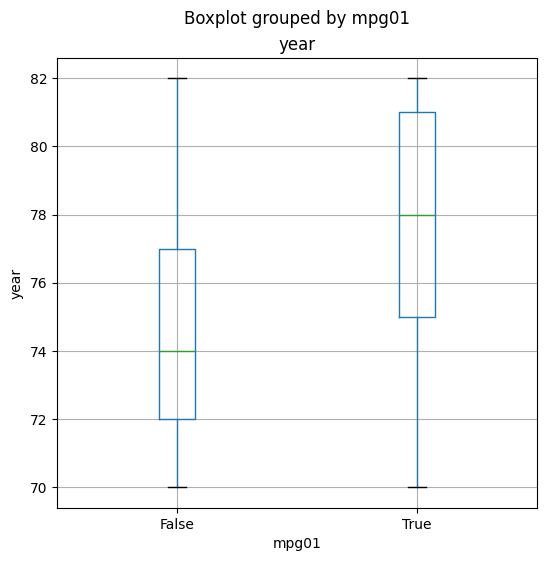

In [41]:
_, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('mpg01')
ax.set_ylabel('year')
Auto.boxplot('year', by='mpg01', ax=ax);

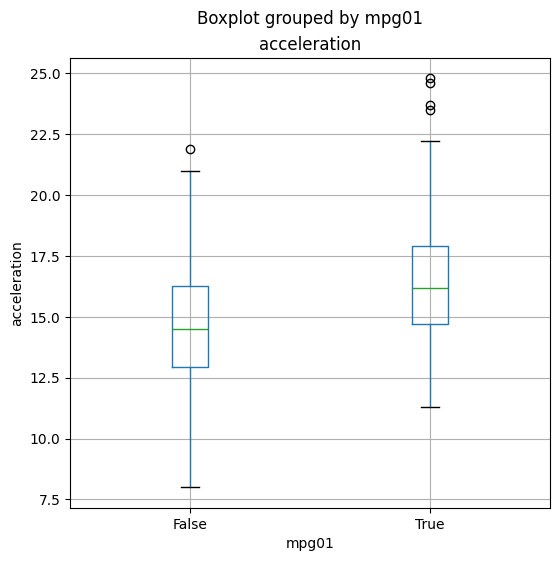

In [42]:
_, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('mpg01')
ax.set_ylabel('acceleration')
Auto.boxplot('acceleration', by='mpg01', ax=ax);

In [43]:
Auto_feats = Auto.loc[:, ['acceleration', 'year', 'origin']]
Auto_mpg01 = Auto['mpg01']
Auto_mpg01.value_counts()

mpg01
False    196
True     196
Name: count, dtype: int64

In [44]:
(X_train, X_test, y_train, y_test) = train_test_split(Auto_feats, Auto_mpg01, test_size=0.33, random_state=42)

In [45]:
X_train.shape, X_test.shape

((262, 3), (130, 3))

### LDA

In [46]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None


In [47]:
lda.means_

array([[14.27460317, 74.50793651,  1.11111111],
       [16.575     , 77.67647059,  1.97058824]])

In [48]:
lda.classes_

array([False,  True])

In [49]:
lda.priors_

array([0.48091603, 0.51908397])

In [50]:
lda.scalings_

array([[0.13069037],
       [0.17493544],
       [1.07801576]])

In [51]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, y_test)

Truth,False,True
Predicted,,
False,52,11
True,18,49


In [52]:
np.mean(lda_pred == y_test), np.mean(lda_pred != y_test)

(0.7769230769230769, 0.2230769230769231)

### QDA

In [53]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

,priors,None
,reg_param,0.0
,store_covariance,True
,tol,0.0001


In [54]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

Truth,False,True
Predicted,,
False,53,9
True,17,51


In [55]:
np.mean(qda_pred == y_test), np.mean(qda_pred != y_test)

(0.8, 0.2)

### Logistic regression

In [56]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [57]:
logit_pred = logit.predict(X_test)
confusion_table(logit_pred, y_test)

Truth,False,True
Predicted,,
False,46,10
True,24,50


In [58]:
np.mean(logit_pred == y_test), np.mean(logit_pred != y_test)

(0.7384615384615385, 0.26153846153846155)

### Naive Bayes

In [59]:
nb = GaussianNB()
nb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [60]:
nb_pred = nb.predict(X_test)
confusion_table(nb_pred, y_test)

Truth,False,True
Predicted,,
False,49,10
True,21,50


In [61]:
np.mean(nb_pred == y_test), np.mean(nb_pred != y_test)

(0.7615384615384615, 0.23846153846153847)

### KNN

In [62]:
knn = KNN(n_neighbors=1)
knn.fit(X_train, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [63]:
knn_pred = knn.predict(X_test)
confusion_table(knn_pred, y_test)

Truth,False,True
Predicted,,
False,50,13
True,20,47


In [64]:
np.mean(knn_pred == y_test), np.mean(knn_pred != y_test)

(0.7461538461538462, 0.25384615384615383)

## Boston dataset

In [65]:
Boston = load_data('Boston')
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [66]:
Boston['crim'].median()

0.25651

In [67]:
high_crim = Boston['crim'] > Boston['crim'].median()
high_crim.value_counts()

crim
False    253
True     253
Name: count, dtype: int64

In [68]:
Boston['high_crim'] = high_crim
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,high_crim
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,False


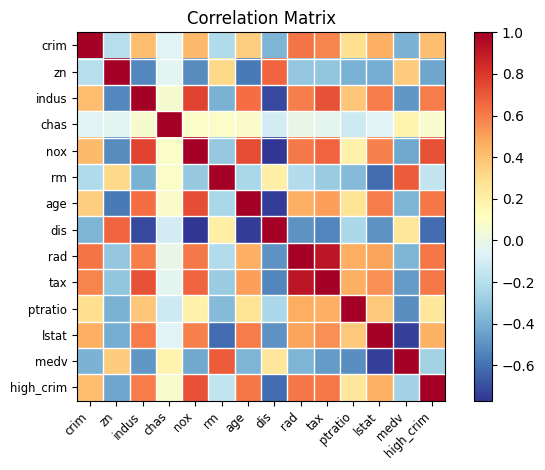

In [69]:
smg.plot_corr(
    Boston.corr(), 
    xnames=Boston.columns, 
    ynames=Boston.columns,
);

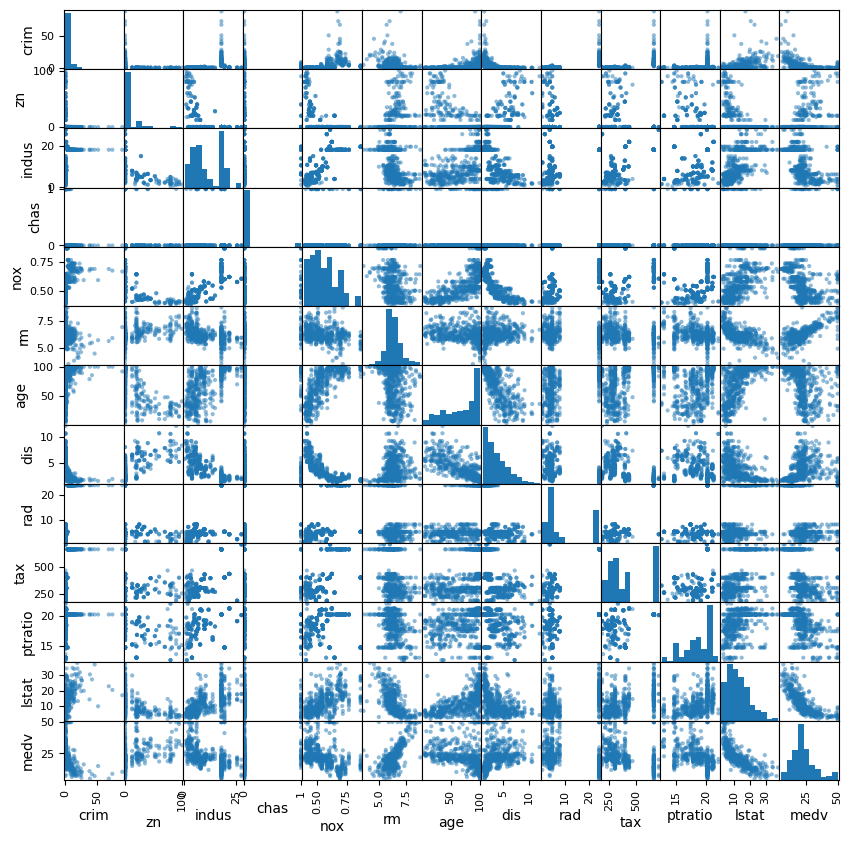

In [70]:
pd.plotting.scatter_matrix(Boston.loc[:, Boston.columns != 'high_crim'], figsize=(10, 10));

In [74]:
exclude = ['crim', 'high_crim', 'medv', 'dis', 'rm', 'zn', 'chas', 'ptratio']
Boston_feats = Boston.loc[:, Boston.columns.drop(exclude)]
Boston_high_crim = Boston['high_crim']
Boston_feats.shape, Boston_high_crim.value_counts()

((506, 6),
 high_crim
 False    253
 True     253
 Name: count, dtype: int64)

In [75]:
(X_train, X_test, y_train, y_test) = train_test_split(Boston_feats, Boston_high_crim, test_size=0.33, random_state=42)

In [76]:
models = [
    LDA(store_covariance=True),
    QDA(store_covariance=True),
    GaussianNB(),
    KNN(n_neighbors=1),
    KNN(n_neighbors=2),
    KNN(n_neighbors=3),
]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy, error_rate = np.mean(pred == y_test), np.mean(pred != y_test)
    print(f"Accuracy: {accuracy*100}, Error: {error_rate*100}")

Accuracy: 82.03592814371258, Error: 17.964071856287426
Accuracy: 84.4311377245509, Error: 15.568862275449103
Accuracy: 80.83832335329342, Error: 19.16167664670659
Accuracy: 88.62275449101796, Error: 11.377245508982035
Accuracy: 89.22155688622755, Error: 10.778443113772456
Accuracy: 89.82035928143712, Error: 10.179640718562874
